### Notebook setup

#### Import shunpiker pre-set packages and modules
 
For an introduction to python packages and modules, see https://realpython.com/python-modules-packages/#python-packages.    

In [1]:
# import shunpiker pre-set packages and modules
%run shunpiker_modules.py

scanpy==1.8.2 anndata==0.7.6 umap==0.5.2 numpy==1.20.3 scipy==1.7.1 pandas==1.3.4 scikit-learn==1.0.1 statsmodels==0.13.0 python-igraph==0.9.8 pynndescent==0.5.5
phenograph== 1.5.7


💡 **Hint:** Use the code below ONLY if you need to install extra packages

In [2]:
#import sys
#!{sys.executable} -m pip install watermark

#### Set notebook parameters

[`%matplotlib inline`](https://ipython.readthedocs.io/en/stable/interactive/tutorial.html#magics-explained) sets output of plotting commands to be displayed directly below the code cell that produced it.


<a id='part_1'></a>

In [3]:
# display plot directly below code cell
%matplotlib inline

## Multi-sample integration

This part guides multisample integration. Make sure that you have run **Step 1** for each of your samples to remove bad quality cells on a per sample basis and store cells of interest for sample integration.

### Read in scRNA-seq raw counts into a python object (multiple samples)

❗ Choose between [cellranger](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/output/overview) and [SEQC](https://github.com/dpeerlab/seqc) data format for your input

Both data inputs will be converted into a scRNA-seq friendly python object called an AnnData object. The AnnData object is  is made up of several components. For a more detailed explanation, see https://anndata.readthedocs.io/en/latest/anndata.AnnData.html#anndata.AnnData. 

Once you execute either of the input commands below, you should be able to access:
- counts: `adata.X` + Run
- gene names: `adata.var` + Run
- cell index and other annotation: `adata.obs` + Run

#### Input SEQC data

🕹️  Provide the path to your raw data and the name of your sample

In [4]:
# type path to your SEQC data folder (replace example path with your path)
path_to_seqc_data = '../data/'

In [5]:
sample_names = ['3000_Vd2_healthy_IGO_12381_48_dense.csv', '3003_Vd2_patients_IGO_12381_54_dense.csv']

Now apply the import_seqc_function to each of these samples. Make sure the combination of the PATH_TO_COUNT_CSV in the import_seqc_data function, combined with each of your sample names, results in the correct paths. The result of the command below will be a list of AnnData objects in the order of your sample names. Reading the csvs might take a few minutes per sample.

In [6]:
adatas_list = [import_seqc_data(path_to_seqc_data, sample) for sample in sample_names] # this may take a few minutes

In [7]:
adata = sc.AnnData.concatenate(
    *adatas_list, # the asterisk unpacks the list containing your AnnData objects. 
    join='outer', 
    batch_key = 'sample', 
    batch_categories = ['Vd2_healthy', 'Vd2_patients'], # or use your sample_names list (as used above) here. 
    # Make sure the order of the batch categories matches that of the AnnData objects 
    index_unique = '.'
)

In [8]:
# randomize the order of cells for plotting
adata.X = np.array(pd.DataFrame(adata.X).fillna(0)) # fill NAs with 0s
np.random.seed(42) 
index_list = np.arange(adata.shape[0])
np.random.shuffle(index_list)
adata = adata[index_list]

In [9]:
adata.shape

(28658, 19129)

### Calculate quality control metrics for your sample before preprocessing

To start, we will calculate some standard quality control (QC) metrics using the `calc_QC_metrics()` function that is defined within the `shunpiker_modules.py` file. The QC metrics calculated include total counts, number of genes, and ribosomal and mitochondrial fraction on a per cell basis.

In [10]:
# caclutate QC metrics for your sample
calc_QC_metrics(adata)

Trying to set attribute `.obs` of view, copying.


❗To check if the QC metrics are now available for your sample, you can run the command below and inspect the column names.

In [11]:
# show top 5 rows from sample metadata (stored in adata.obs)
adata.obs.head()

,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,original_total_counts,log10_original_total_counts,mito_frac,RBP_frac
cell_barcodes,,,,,,,,,,,,,
122490832963420.Vd2_patients,Vd2_patients,1951,7.576610,5111.0,8.539346,36.939933,45.548816,55.018587,68.812365,5111.0,3.708506,0.067306,0.155351
169038986000667.Vd2_healthy,Vd2_healthy,1136,7.036148,3283.0,8.096817,42.308864,56.381359,66.463600,80.627475,3283.0,3.516271,0.040512,0.386232
191689554521437.Vd2_patients,Vd2_patients,960,6.867974,2905.0,7.974533,41.824441,57.452668,69.776248,84.165232,2905.0,3.463146,0.055077,0.368675
232236074289510.Vd2_healthy,Vd2_healthy,2015,7.608871,6287.0,8.746398,37.219660,49.689836,59.901384,72.801018,6287.0,3.798444,0.059806,0.280897
196662873504995.Vd2_patients,Vd2_patients,2309,7.745003,8912.0,9.095266,41.124327,54.847397,64.317774,75.673250,8912.0,3.949975,0.071701,0.342796


### Data "clean-up": removal of not expressed genes

Genes with zero counts across all cells will not provide any biological insight, but rather delay some of the downstream processing steps, thus we choose to remove genes that are not expressed in any cells. You can make this step more stringend by asking genes to be expressed in at least N number of cells.

In [12]:
# remove genes that are not expressed in any cells (remove columns with all 0s)
sc.pp.filter_genes(adata, min_cells=1)

### Data "clean-up": removal of rRNA

Ribosomal protein (RBP) RNA often constitutes between 20-50% of your counts. Variation in their expression can therefore highly affect the outcome of your visualization algorithms and differential gene expression analyses. Our experience is that expression levels of RBP RNA often cannot be reproduced or validated, and are moreover difficult to interpret. One can therefore decide to remove these genes from the data altogether.

In [13]:
adata = remove_RBs(adata)

### Data "clean-up": data normalization

RNA counts generally vary linearly with library size: RNA molecules have a steady concentration rather than a steady absolute number (Additional variation suggests biological variation in gene expression among your cells). Therefore, it is usually appropriate to normalize each cell to the same total library size, thereby converting RNA counts to a relative rather than absolute count. Below a random gene is plotted against library size to show that expression, at least if not variable between cell types in your sample, changes according to library size. We take a gene with a minimum gene expression of 1, because trends in genes with low mean expression are occluded by noise. Run the cell below a few times to inspect the general trend between gene expression and library size. Note that scRNA-seq data is highly noisy, and the correlation will therefore be noisy as well in genes with lower expression.

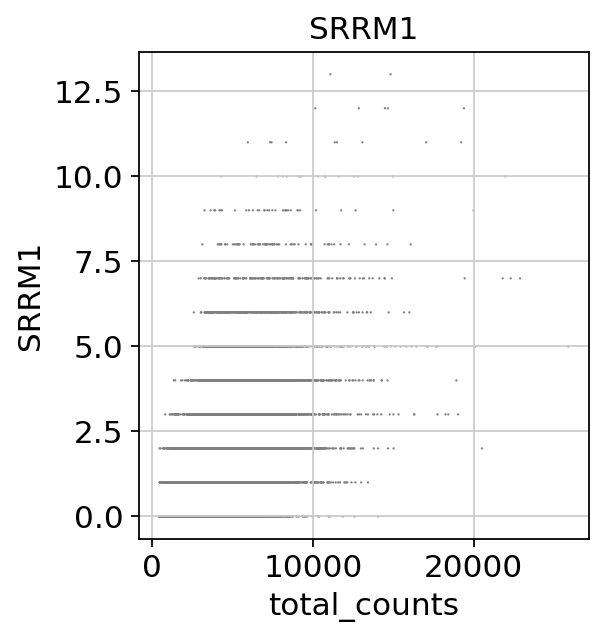

In [14]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)
observe_library_size_effect(adata)

An alternative method to normalize data is using SCRAN that applies a similar principle to common normalization methods in bulk RNA data.

Here we will normalize to a total library size of 10,000. Scanpy will update our count matrix (adata.X) automatically with the normalized counts.

In [15]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=10**4)

Trying to set attribute `.obs` of view, copying.


### Data "clean-up": log-transformation

Log transformation makes changes in expression relative rather than absolute (e.g. it looks at doubling (when using log2) of expression rather than increase of n counts in expression). It makes the differences between highly and lowly expressed genes smaller, and limits the effects of highly expressed genes on your data analysis. It is often considered a default part of preprocessing, but can occasionally be better left out. The desired effect of a log-transformation is that it brings out biological differences between your cell populations better. <br>
Scanpy's log transformation function takes the natural logarithm of each (count + 1), and updates your count matrix (adata.X): 

In [16]:
sc.pp.log1p(adata)

In [17]:
# Data annotation

In [18]:
# add hashtag annotation
hashtags_h = sc.read_h5ad("../data/3000_Vd2_healthy_HTO.h5ad")
hashtags_p = sc.read_h5ad("../data/3003_Vd2_patients_HTO.h5ad")

In [21]:
hashtags = sc.AnnData.concatenate(
    hashtags_h,hashtags_p, # the asterisk unpacks the list containing your AnnData objects. 
    join='outer', 
    batch_key = 'status', 
    batch_categories = ['Vd2_healthy', 'Vd2_patients'], # or use your sample_names list (as used above) here. 
    # Make sure the order of the batch categories matches that of the AnnData objects 
    index_unique = '.'
)

In [22]:
adata_copy = adata[hashtags.obs.index].copy()

In [23]:
adata = adata_copy

In [24]:
adata.obs['hash_id'] = hashtags.obs['hash_id']

In [25]:
adata.obs['status'] = hashtags.obs['status']

In [26]:
adata.obs['hash+status'] = ''
adata.obs['hash+status'] = adata.obs[['hash_id', 'status']].agg('_'.join, axis=1)

### Data "clean-up": remove bad quality cells

🕹️ Add path to your good quality cell sample that you have stored already using Step 1.

In [27]:
Vd2_healthy_QC = pd.read_pickle("files/Vd2_healthy_QCpassed.pkl")
Vd2_healthy_QCv2 = Vd2_healthy_QC + '.Vd2_healthy'
Vd2_healthy_QCv2.columns = ['cell_barcodes']
Vd2_patients_QC = pd.read_pickle("files/Vd2_patients_QCpassed.pkl")
Vd2_patients_QCv2 = Vd2_patients_QC + '.Vd2_patients'
Vd2_patients_QCv2.columns = ['cell_barcodes']

In [28]:
# concatenate samples
QC = pd.concat([Vd2_healthy_QCv2, Vd2_patients_QCv2], ignore_index=True)

In [29]:
QC.shape

(25531, 1)

Check the number of all cells for your integrated samples.

In [30]:
adata.shape

(28655, 18957)

Add good/bad quality cell annotation to a new variable in your anndata object and check the number of good quality cells that will be maintained after the filtering.

In [31]:
adata.obs['QC'] = adata.obs.index.isin(QC.iloc[:,0])

In [32]:
adata[adata.obs['QC']!=False].shape

(25529, 18957)

In [33]:
adata.obs['keep_cell'] = ['yes' if x==True else 'no' for x in adata.obs['QC']] 

In [34]:
rng = np.random.RandomState(42)
sc.tl.pca(adata, n_comps=50, svd_solver='arpack', random_state=rng)
sc.pp.neighbors(adata, n_neighbors=15)
sc.tl.umap(adata)

In [ ]:
# observe good/bad quality cells annotation and assorted quality metrics on a UMAP before their removal

/home/kousaa/miniconda3/envs/AK011_py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'hash+status' as categorical
/home/kousaa/miniconda3/envs/AK011_py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'keep_cell' as categorical


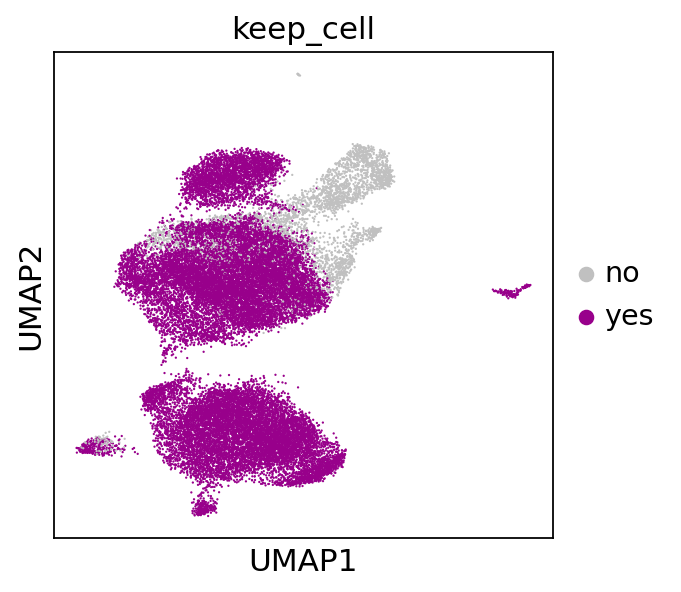

In [35]:
adata.uns['keep_cell_colors'] = [  "#C0C0C0", "#98008B"]
# quick pick at your cells to be removed
sc.pl.umap(
    adata, 
    color=['keep_cell'], 
    ncols=3,
    wspace = 0.3,
    sort_order = False
)

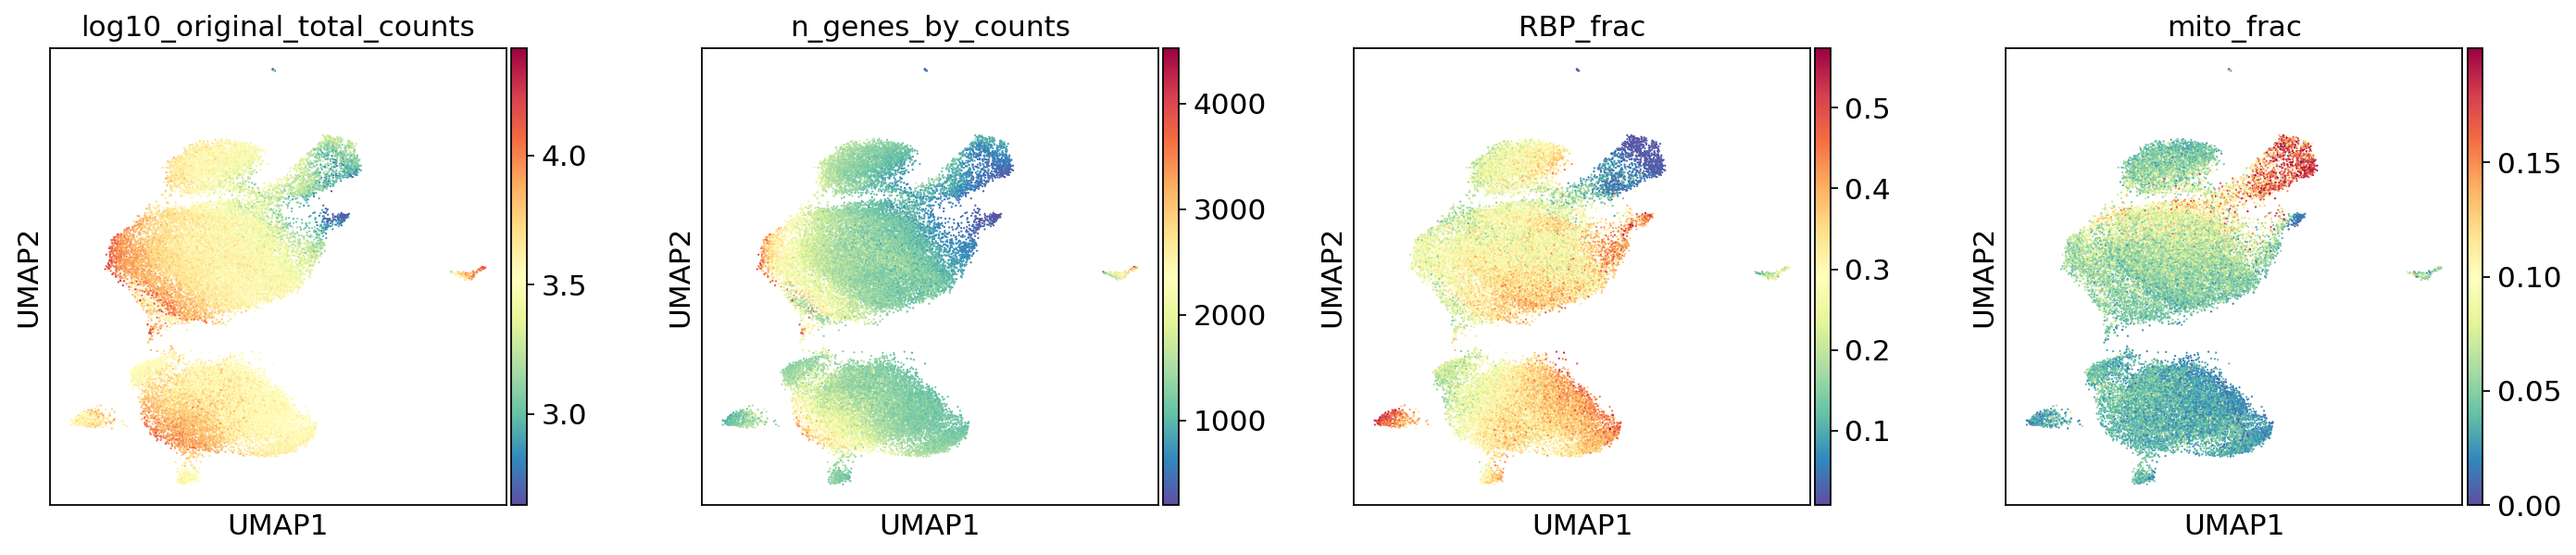

In [36]:
# inspect the QC metrics
sc.pl.umap(
    adata, 
    color=['log10_original_total_counts', 'n_genes_by_counts','RBP_frac', 'mito_frac'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.3,
    sort_order = False
)

❗ This next command will remove bad quality cells.

In [37]:
adata = adata[adata.obs['QC']!=False]

In [37]:
# Remove doublet cells from annotation

Trying to set attribute `.uns` of view, copying.


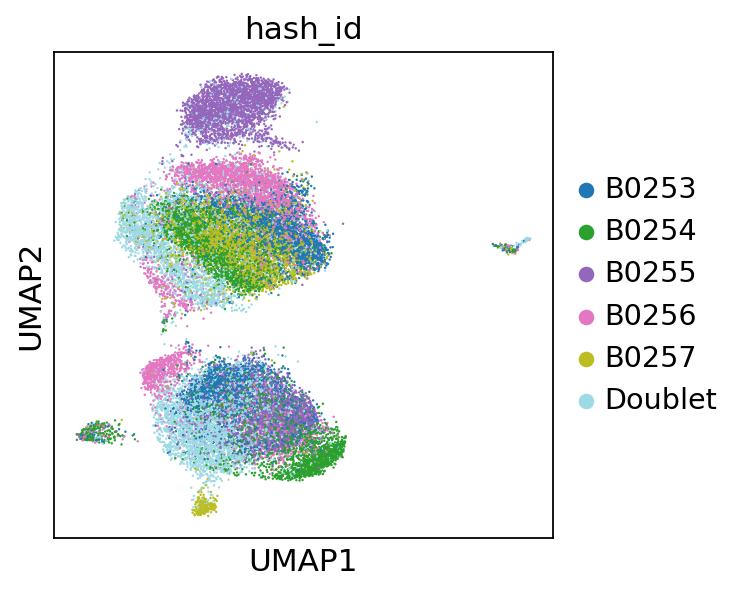

In [38]:
# inspect the QC metrics
sc.pl.umap(
    adata, 
    color=['hash_id'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.3,
    sort_order = False
)

In [39]:
adata = adata[adata.obs['hash_id']!='Doublet']

Trying to set attribute `.uns` of view, copying.


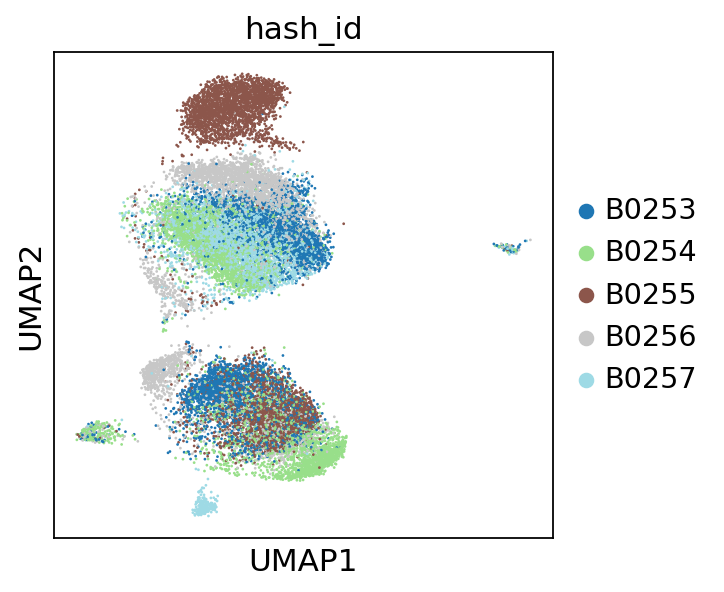

In [40]:
# inspect the QC metrics
sc.pl.umap(
    adata, 
    color=['hash_id'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.3,
    sort_order = False
)

### Let's have a look at the integrated data

In [41]:
rng = np.random.RandomState(42)
adata = sc.tl.pca(adata, n_comps=200, copy = True, svd_solver='arpack', random_state=rng)

We can visualize the percentage of variance explained by each PC. Based on this figure, we will select a number of principal components to use in the rest of our analysis. 

<function matplotlib.pyplot.show(close=None, block=None)>

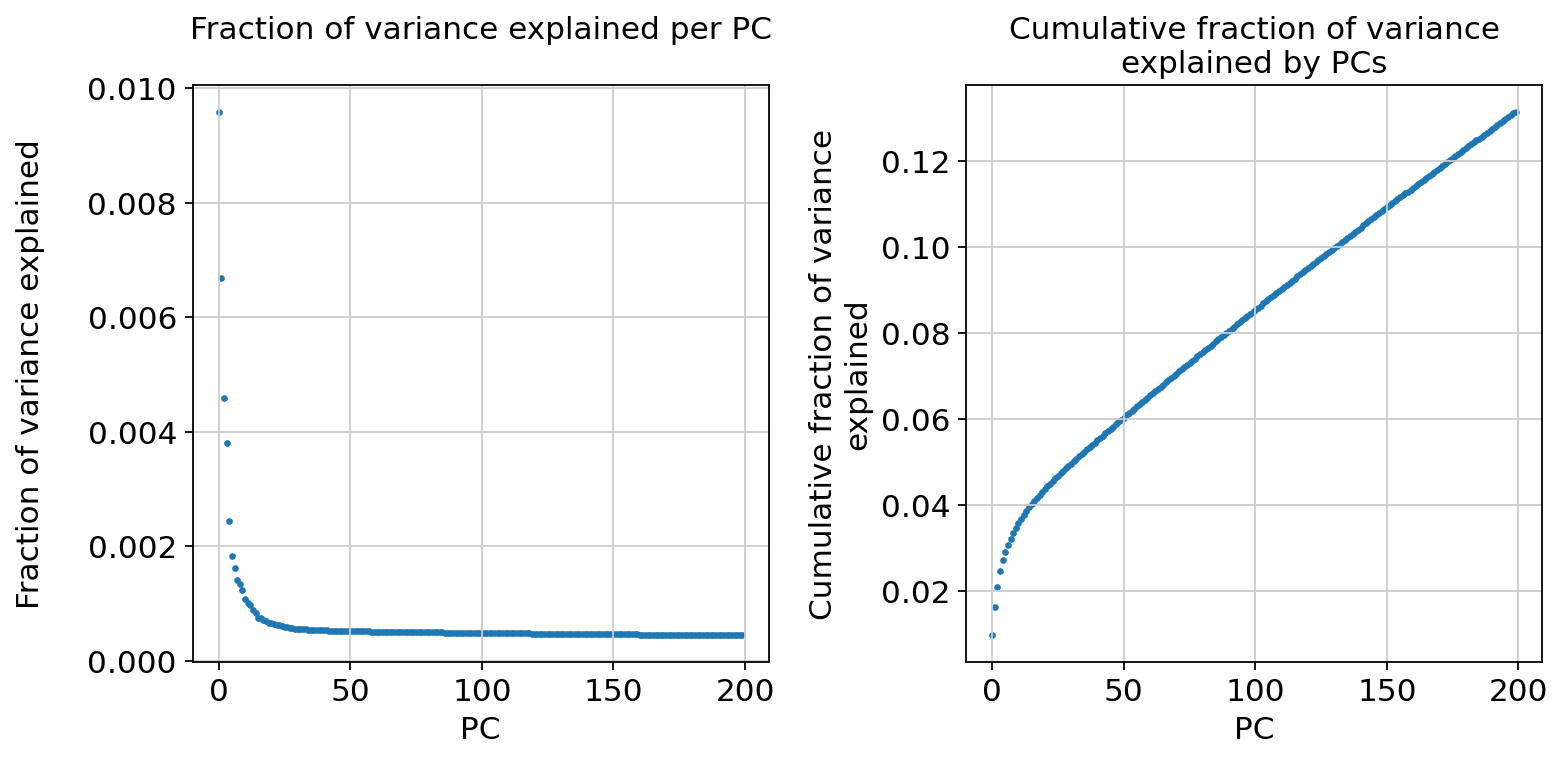

In [42]:
observe_variance(adata)

❗ We want to include all the principal components before the 'knee point' (the point where the fitted curve would change slope the most), because these likely represent important sources of variance in our data. To try to avoid eliminating any relevant but small sources of variance, we will choose a number of PCs slightly to the right of the knee point. 

Replace the number below with your selection and run PCA again.

In [48]:
rng = np.random.RandomState(42)
sc.tl.pca(adata, n_comps=40, svd_solver='arpack', random_state=rng)
sc.pp.neighbors(adata, n_neighbors=15)
sc.tl.umap(adata)

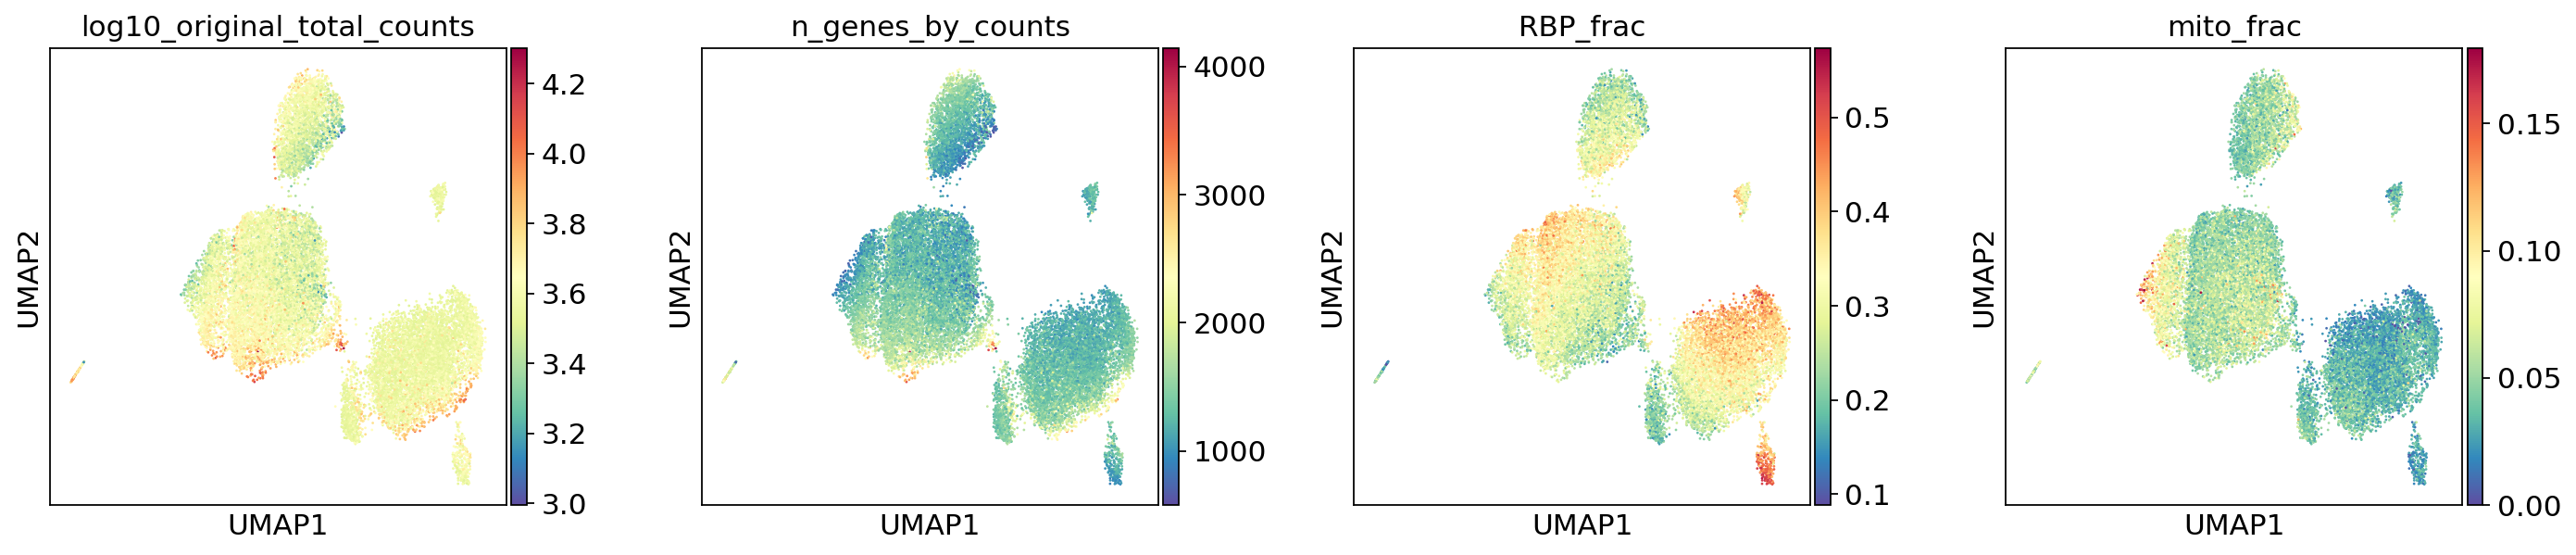

In [49]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)

# inspect the QC metrics
sc.pl.umap(
    adata, 
    color=['log10_original_total_counts', 'n_genes_by_counts','RBP_frac', 'mito_frac'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.3,
    sort_order = False
)

In [50]:
adata.obs['condition'] = ['healthy' if 'healthy' in x else 'patient' if 'patient' in x else 'ERROR' for x in adata.obs['sample']]

In [51]:
adata.uns['condition_colors'] = ['#B4C540', '#842D73']

/home/kousaa/miniconda3/envs/AK011_py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'condition' as categorical


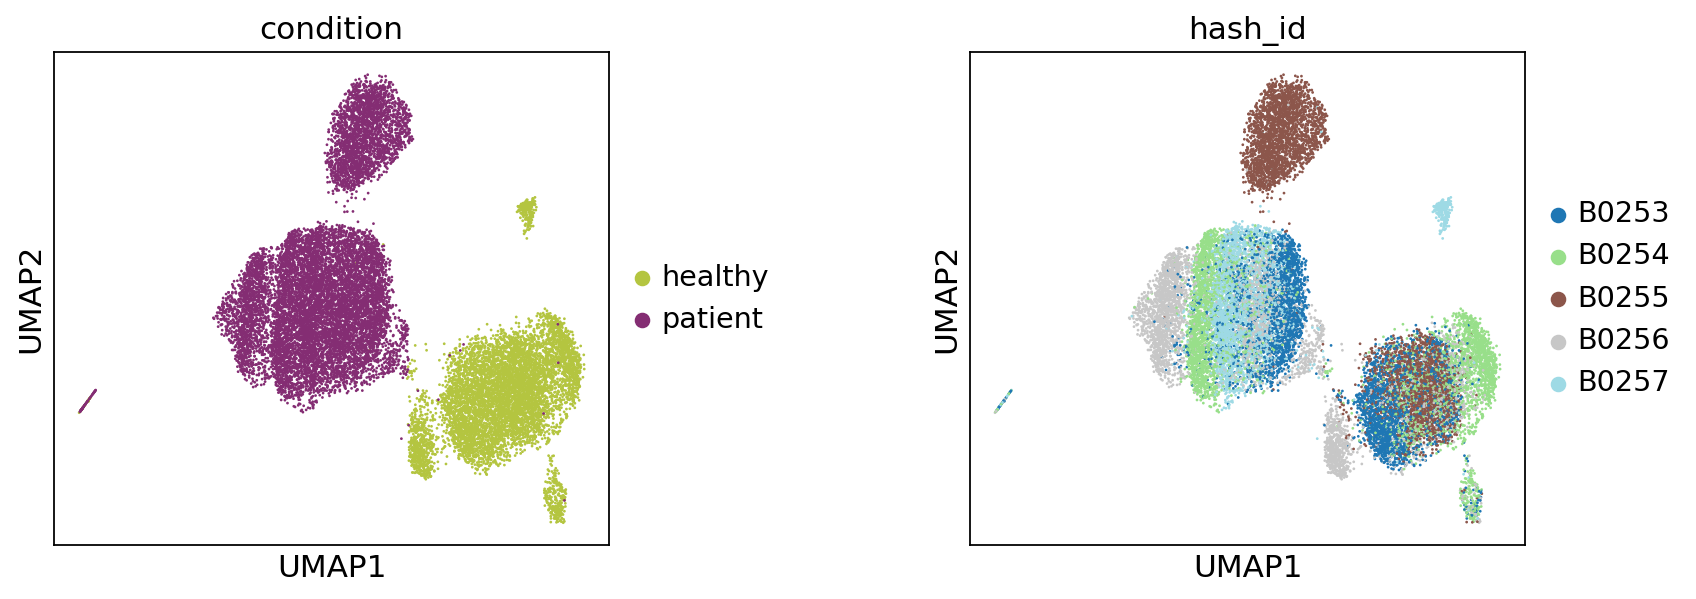

In [52]:
# inspect the QC metrics
sc.pl.umap(
    adata, 
    color=['condition', 'hash_id'], 
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.5,
    sort_order = False
)

### Unsupervised clustering analysis using PhenoGraph

In [53]:
# calculate clustering characteristics for a range of ks (5 to 155), by a step of 5.
ks = np.arange(5,155,5)
cluster_chars = [calc_clustering_characteristics(k, adata.obsm['X_pca']) for k in ks];

Finding 5 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 22.51021099090576 seconds
Jaccard graph constructed in 29.80895471572876 seconds
Wrote graph to binary file in 0.13131046295166016 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.940893
After 3 runs, maximum modularity is Q = 0.942083
Louvain completed 23 runs in 137.77176451683044 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 217.1843204498291 seconds
Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 24.770700693130493 seconds
Jaccard graph constructed in 31.091068267822266 seconds
Wrote graph to binary file in 0.32056665420532227 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.85784
Louvain completed 21 runs in 29.517009258270264 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 111.37398314476013 seconds
Fi

Wrote graph to binary file in 3.3648805618286133 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.801722
Louvain completed 21 runs in 65.0776047706604 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 230.74529838562012 seconds
Finding 90 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 23.717650413513184 seconds
Jaccard graph constructed in 131.9561767578125 seconds
Wrote graph to binary file in 3.7991511821746826 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.799183
Louvain completed 21 runs in 297.78434014320374 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 483.3565626144409 seconds
Finding 95 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 22.96238422393799 seconds
Jaccard graph constructed in 126.5303544998169 seconds
Wrote graph to binary file in 3.785428762435913 second

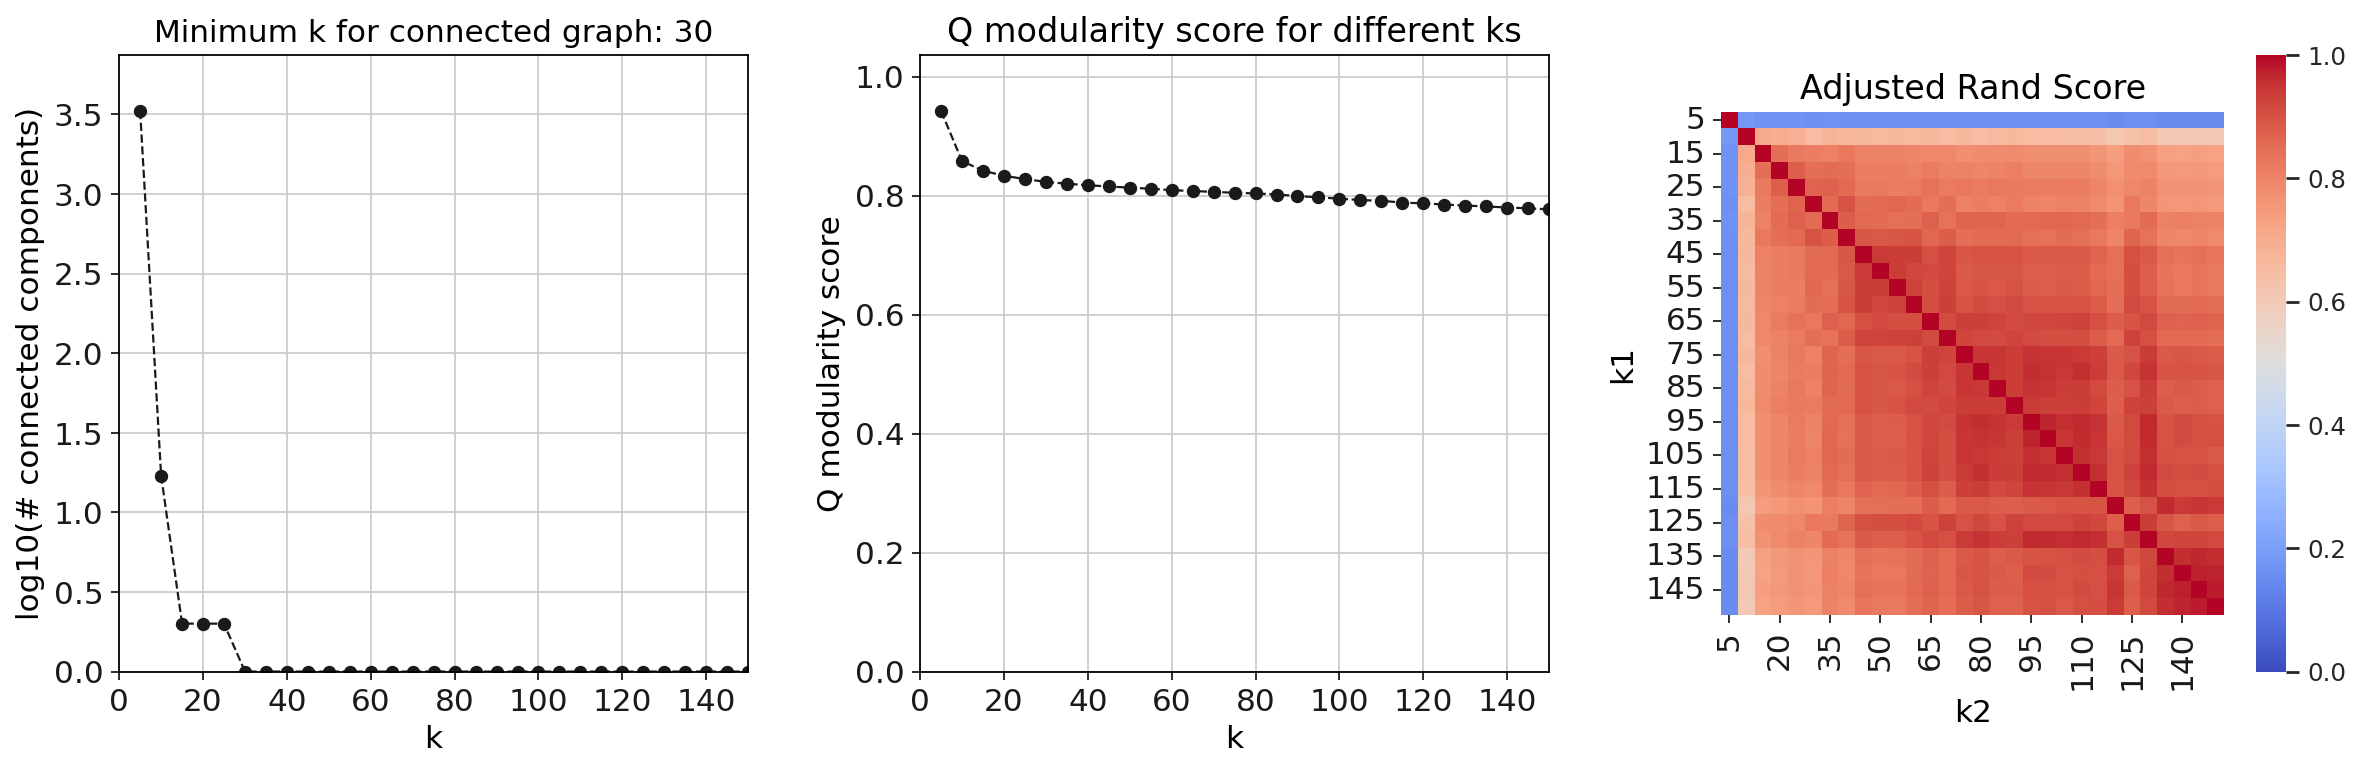

In [54]:
Rand_index_df = inspect_clustering_chars(ks, cluster_chars)

In [63]:
Rand_index_df.iloc[1:10,1:15]

k2,10,15,20,25,30,35,40,45,50,55,60,65,70,75
k1,,,,,,,,,,,,,,
10,1.000000,0.708361,0.697918,0.690948,0.655561,0.678668,0.667860,0.661260,0.658160,0.660221,0.658601,0.661602,0.653545,0.660167
15,0.708361,1.000000,0.847029,0.823620,0.815601,0.806029,0.824827,0.805716,0.803845,0.800954,0.800572,0.792872,0.791310,0.774893
20,0.697918,0.847029,1.000000,0.877597,0.844167,0.851508,0.847221,0.813446,0.812510,0.813589,0.808102,0.818450,0.803565,0.803034
25,0.690948,0.823620,0.877597,1.000000,0.868843,0.874362,0.857790,0.822046,0.824047,0.813366,0.820228,0.836515,0.816623,0.825768
30,0.655561,0.815601,0.844167,0.868843,1.000000,0.853823,0.898463,0.850691,0.857952,0.860906,0.849150,0.827265,0.845287,0.805484
35,0.678668,0.806029,0.851508,0.874362,0.853823,1.000000,0.881877,0.858541,0.851711,0.842514,0.846990,0.872004,0.839639,0.864437
40,0.667860,0.824827,0.847221,0.857790,0.898463,0.881877,1.000000,0.894475,0.890608,0.893886,0.896844,0.863104,0.882459,0.847176
45,0.661260,0.805716,0.813446,0.822046,0.850691,0.858541,0.894475,1.000000,0.939130,0.934890,0.937441,0.904261,0.923512,0.893665
50,0.658160,0.803845,0.812510,0.824047,0.857952,0.851711,0.890608,0.939130,1.000000,0.936857,0.919470,0.916687,0.923094,0.885553


In [64]:
# add your selected k value here to proceed
k=30
communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata.obsm['X_pca']),k=k)
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 23.55879521369934 seconds
Jaccard graph constructed in 35.89361643791199 seconds
Wrote graph to binary file in 1.6971054077148438 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.822875
Louvain completed 21 runs in 42.060298204422 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 116.23827981948853 seconds


We can visualize the clustering to see which clusters match with the cells that we would like to filter out. Inspect the list of QC metrics and canonical markers to make your choice.

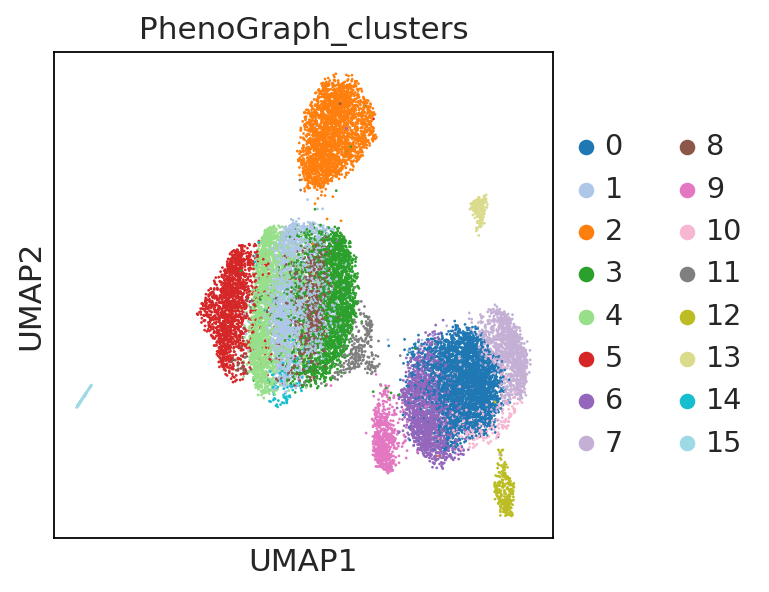

In [65]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.5,
    sort_order = False
)

You are done! Just save your integrated file as an h5ad object. Make sure your path ends with the desired filename including the .h5ad file extension. You can now come back to this dataset at anytime.

In [66]:
path_to_h5ad = '/home/kousaa/scRNAseq-analysis/[AK011] Hana_unconvencional-Tcells/notebooks/files/Vd2.h5ad'

In [67]:
adata.write(path_to_h5ad)

In [5]:
adata = sc.read_h5ad(path_to_h5ad)

In [60]:
adata.shape

(19674, 18957)

In [68]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [69]:
%watermark

Last updated: 2021-12-02T05:07:01.321962-05:00

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.29.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 3.10.0-957.12.2.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 72
Architecture: 64bit

